<a href="https://colab.research.google.com/github/sharma-chandan/generate_letters_in_different_font/blob/master/bbox_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Mount Google drive (change code for local machine). We need to copy generate_dataset.py script to current directory
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!mkdir JPEGImages
!mkdir Annotations
!cp "/gdrive/My Drive/Colab Notebooks/caps_project/random scripts/reset_bbox/images/0a1c9dc21357687274d342b9d6d38a88.jpg" JPEGImages/
#Move all xml files to Annotations folder, this is needed for python script used next
!cp "/gdrive/My Drive/Colab Notebooks/caps_project/random scripts/reset_bbox/xml/0a1c9dc21357687274d342b9d6d38a88.xml" Annotations/
#Copy generate_dataset.py file to current directory
!cp "/gdrive/My Drive/Colab Notebooks/18-04-2020/ACV - I/Notebooks/Detection/xml_to_csv.py" .


mkdir: cannot create directory ‘JPEGImages’: File exists
mkdir: cannot create directory ‘Annotations’: File exists
Successfully converted xml to csv.


In [451]:
#Generate csv file from XML file
!python xml_to_csv.py -i Annotations -o vehicle.csv

Successfully converted xml to csv.


In [0]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [0]:
#Read csv file as pandas dataframe
df = pd.read_csv('vehicle.csv')

In [0]:
#convert all class name to capital letters
df['class'] = df['class'].str.upper()
#delete all classes except A-Z, 0-9, LICENSE_PLATE
df.drop(df[(df['class'].map(len) > 1) & (df['class'] != 'LICENSE_PLATE')].index, inplace = True)
#Calculate Height and width of the bounding box based on co-ordinates
df['bwidth'] = (df['xmax']-df['xmin'])
df['bheight'] = (df['ymax']-df['ymin'])

In [455]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax,bwidth,bheight
0,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,LICENSE_PLATE,433,385,531,432,98,47
1,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,A,444,414,453,431,9,17
2,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,P,453,413,461,431,8,18
3,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,2,459,410,467,428,8,18
4,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,8,466,409,474,426,8,17
5,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,A,475,407,485,425,10,18
6,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,A,483,406,492,424,9,18
7,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,1,494,405,500,419,6,14
8,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,9,500,403,506,420,6,17
9,f3e64142edac4111e2d23a3b54ee36d6_large.jpg,640,480,1,505,401,512,417,7,16


In [456]:
all_classes = df['filename'].unique()
all_classes

array(['f3e64142edac4111e2d23a3b54ee36d6_large.jpg',
       '0a1c9dc21357687274d342b9d6d38a88.jpg',
       '0f78ff8f4d66d750f355ddf1a512996f_large.jpg'], dtype=object)

In [457]:
!mkdir cropped_images
!rm -f cropped_images/*

mkdir: cannot create directory ‘cropped_images’: File exists


In [0]:
def crop_img(image_data):
  image_data.reset_index(drop=True,inplace=True)
  image_name = image_data.loc[0,'filename']
  img = cv2.imread('/content/JPEGImages/' + image_name)
  xmin, ymin, xmax, ymax = image_data.loc[0, ['xmin', 'ymin', 'xmax', 'ymax']]
  cropped_image = img[ymin:ymax, xmin:xmax]
  
  cv2.imwrite('/content/cropped_images/'+image_name,cropped_image)

In [0]:
def process_image(img_data):
  lp_data = pd.DataFrame(img_data[img_data['class'] == 'LICENSE_PLATE'])
  img_data.drop(img_data[img_data['class'] == 'LICENSE_PLATE'].index,inplace = True)
  crop_img(lp_data)
  img_data['n_xmin'] = img_data['xmin'] - lp_data.loc[0,'xmin']
  img_data['n_ymin'] = img_data['ymin'] - lp_data.loc[0,'ymin']
  img_data['n_xmax'] = img_data['n_xmin'] + img_data['bwidth']
  img_data['n_ymax'] = img_data['n_ymin'] + img_data['bheight']
  return img_data
  

In [460]:
new_df = pd.DataFrame(columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'bwidth', 'bheight', 'n_xmin', 'n_ymin', 'n_xmax', 'n_ymax'])
for i in all_classes:
  #print(i)
  df_new = pd.DataFrame(df[df['filename'] == i])
  res = process_image(df_new)
  #print(res)
  new_df = new_df.append(res,ignore_index=True)
  print(new_df)

                                     filename width height  ... n_ymin n_xmax n_ymax
0  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     29     20     46
1  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     28     28     46
2  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     25     34     43
3  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     24     41     41
4  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     22     52     40
5  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     21     59     39
6  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     20     67     34
7  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     18     73     35
8  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     16     79     32
9  f3e64142edac4111e2d23a3b54ee36d6_large.jpg   640    480  ...     15     86     30

[10 rows x 14 columns]
                                      fil

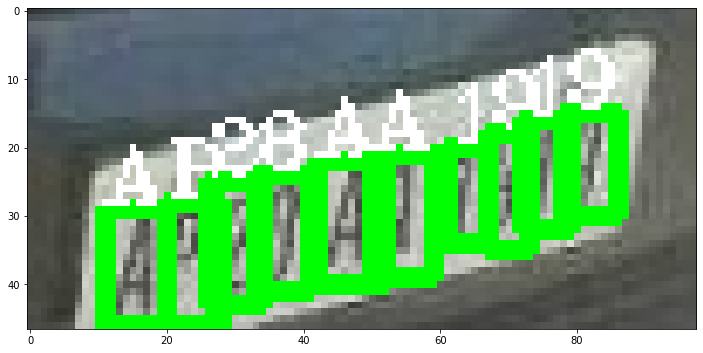

In [470]:
#Pickup a random image number
img_num = np.random.randint(0, new_df.shape[0])

#Read the image
img_file = new_df.loc[img_num,'filename']
#print(img_file)
img = cv2.imread('cropped_images/' + img_file)

#Find all rows which have same file name
rows_with_file = new_df[new_df['filename'] == img_file].index.tolist()

#Draw rectangle(s) as per bounding box information
for i in rows_with_file:

    #Get bounding box
    xmin, ymin, xmax, ymax = new_df.loc[i, ['n_xmin', 'n_ymin', 'n_xmax', 'n_ymax']]
    #Get Label
    label = new_df.loc[i, 'class']
    #Add bounding box
    cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,255,0), 2)
    #Add text
    cv2.putText(img,label,(xmin, ymin-1),cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.6, (255, 255, 255), 1)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.figure(figsize=(12,10))
plt.imshow(img)
plt.show()